In [ ]:
import pandas as pd
import seaborn as sns
import PIL
import os
import nibabel as nib
from scipy import ndimage
import numpy as np
from sklearn.model_selection import train_test_split
from random import randint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from IPython.display import Image, display
from PIL import ImageOps
import random
import skimage
import cv2
from skimage.measure import compare_psnr, compare_ssim
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import time
import argparse
from tensorflow.keras.preprocessing.image import load_img

%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Carga de imágenes**

In [ ]:
#Se cambio la ruta para trabajar con archivos descargados desde el drive
!unzip -q drive/MyDrive/TAC-GRUPOF/ProyectoFinDeCurso/Implementación/raindrop_data/test_a.zip

In [ ]:
#Se cambio la ruta para trabajar con archivos descargados desde el drive
!unzip -q drive/MyDrive/TAC-GRUPOF/ProyectoFinDeCurso/Implementación/raindrop_data/train.zip

In [ ]:
target_dir = "train/data/"
input_dir = "train/gt"

In [ ]:
img_size = (160, 160)
num_classes = 3 #Number of colors
batch_size = 32

In [ ]:
input_img_paths = sorted([os.path.join(input_dir, file_name) for file_name in os.listdir(input_dir) if file_name.endswith(".png")])
target_img_paths = sorted([os.path.join(target_dir, file_name) for file_name in os.listdir(target_dir) if file_name.endswith(".png") and not file_name.startswith(".")])

In [ ]:
target_img_paths

['train/data/0_rain.png',
 'train/data/100_rain.png',
 'train/data/101_rain.png',
 'train/data/102_rain.png',
 'train/data/103_rain.png',
 'train/data/104_rain.png',
 'train/data/105_rain.png',
 'train/data/106_rain.png',
 'train/data/107_rain.png',
 'train/data/108_rain.png',
 'train/data/109_rain.png',
 'train/data/10_rain.png',
 'train/data/110_rain.png',
 'train/data/111_rain.png',
 'train/data/112_rain.png',
 'train/data/113_rain.png',
 'train/data/114_rain.png',
 'train/data/115_rain.png',
 'train/data/116_rain.png',
 'train/data/117_rain.png',
 'train/data/118_rain.png',
 'train/data/119_rain.png',
 'train/data/11_rain.png',
 'train/data/120_rain.png',
 'train/data/121_rain.png',
 'train/data/122_rain.png',
 'train/data/123_rain.png',
 'train/data/124_rain.png',
 'train/data/125_rain.png',
 'train/data/126_rain.png',
 'train/data/127_rain.png',
 'train/data/128_rain.png',
 'train/data/129_rain.png',
 'train/data/12_rain.png',
 'train/data/130_rain.png',
 'train/data/131_rain.png

In [ ]:
#Validamos que el numero de imagenes del input como del target sea el mismo
len(input_img_paths), len(target_img_paths)

(861, 861)

In [ ]:
for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
  print("{} -------> {}".format(input_path, target_path))

train/gt/0_clean.png -------> train/data/0_rain.png
train/gt/100_clean.png -------> train/data/100_rain.png
train/gt/101_clean.png -------> train/data/101_rain.png
train/gt/102_clean.png -------> train/data/102_rain.png
train/gt/103_clean.png -------> train/data/103_rain.png


In [ ]:
def display_sample(index, input_img_paths, target_img_paths):
  display(Image(filename=input_img_paths[sample_number]))

  img = ImageOps.autocontrast(load_img(target_img_paths[sample_number]))

  display(img)

In [ ]:
sample_number = 1

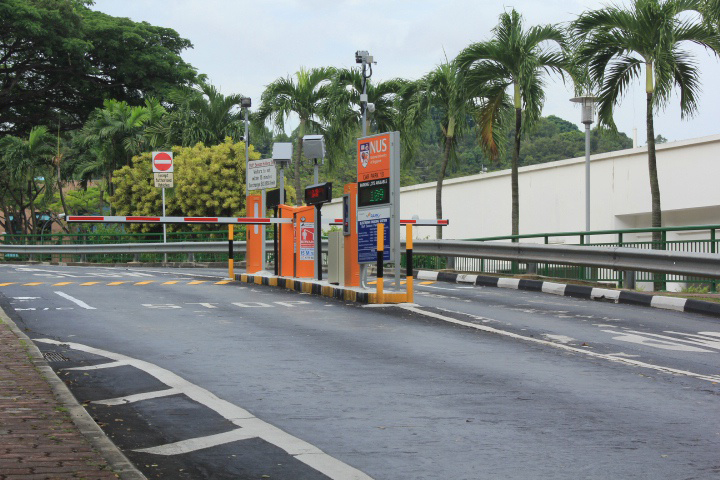

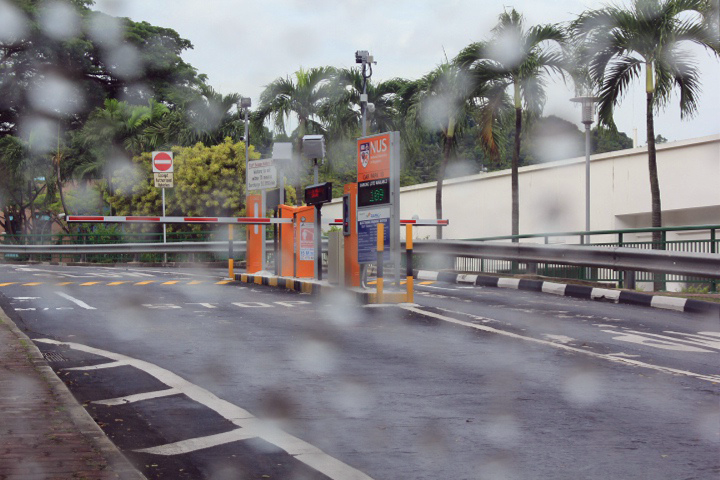

In [ ]:
#Imprimimos las imagenes
display_sample(sample_number, input_img_paths, target_img_paths)

##**Modelo**

In [ ]:
#Establecer tiempo de iteración
ITERATION = 4

#Modelo
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.det_conv0 = nn.Sequential(
            nn.Conv2d(4, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv3 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv4 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.det_conv5 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.conv_i = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_f = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_g = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Tanh()
            )
        self.conv_o = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.det_conv_mask = nn.Sequential(
            nn.Conv2d(32, 1, 3, 1, 1),
            )
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 64, 5, 1, 2),
            nn.ReLU()
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU()
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU()
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU()
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
            )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
            )
        self.diconv1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 2, dilation = 2),
            nn.ReLU()
            )
        self.diconv2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 4, dilation = 4),
            nn.ReLU()
            )
        self.diconv3 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 8, dilation = 8),
            nn.ReLU()
            )
        self.diconv4 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 16, dilation = 16),
            nn.ReLU()
            )
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
            )
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
            )
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReflectionPad2d((1, 0, 1, 0)),
            nn.AvgPool2d(2, stride = 1),
            nn.ReLU()
            )
        self.conv9 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU()
            )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReflectionPad2d((1, 0, 1, 0)),
            nn.AvgPool2d(2, stride = 1),
            nn.ReLU()
            )
        self.conv10 = nn.Sequential(
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.outframe1 = nn.Sequential(
            nn.Conv2d(256, 3, 3, 1, 1),
            nn.ReLU()
            )
        self.outframe2 = nn.Sequential(
            nn.Conv2d(128, 3, 3, 1, 1),
            nn.ReLU()
            )
        self.output = nn.Sequential(
            nn.Conv2d(32, 3, 3, 1, 1)
            )
    
    def forward(self, input):
        batch_size, row, col = input.size(0), input.size(2), input.size(3)
        mask = Variable(torch.ones(batch_size, 1, row, col)).cuda() / 2.
        h = Variable(torch.zeros(batch_size, 32, row, col)).cuda() 
        c = Variable(torch.zeros(batch_size, 32, row, col)).cuda()
        mask_list = []
        for i in range(ITERATION):
            x = torch.cat((input, mask), 1)
            x = self.det_conv0(x)
            resx = x
            x = F.relu(self.det_conv1(x) + resx)
            resx = x
            x = F.relu(self.det_conv2(x) + resx)
            resx = x
            x = F.relu(self.det_conv3(x) + resx)
            resx = x
            x = F.relu(self.det_conv4(x) + resx)
            resx = x
            x = F.relu(self.det_conv5(x) + resx)
            x = torch.cat((x, h), 1)
            i = self.conv_i(x)
            f = self.conv_f(x)
            g = self.conv_g(x)
            o = self.conv_o(x)
            c = f * c + i * g
            h = o * F.tanh(c)
            mask = self.det_conv_mask(h)
            mask_list.append(mask)
        x = torch.cat((input, mask), 1)
        x = self.conv1(x)
        res1 = x
        x = self.conv2(x)
        x = self.conv3(x)
        res2 = x
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.diconv1(x)
        x = self.diconv2(x)
        x = self.diconv3(x)
        x = self.diconv4(x)
        x = self.conv7(x)
        x = self.conv8(x)
        frame1 = self.outframe1(x)
        x = self.deconv1(x)
        x = x + res2
        x = self.conv9(x)
        frame2 = self.outframe2(x)
        x = self.deconv2(x)
        x = x + res1
        x = self.conv10(x)
        x = self.output(x)
        return mask_list, frame1, frame2, x

In [ ]:
model = Generator().cuda()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/TAC-GRUPOF/ProyectoFinDeCurso/Implementación/gen.pkl'))

<All keys matched successfully>

In [ ]:
def align_to_four(img):
    #Alinear a 4
    a_row = int(img.shape[0]/4)*4
    a_col = int(img.shape[1]/4)*4
    img = img[0:a_row, 0:a_col]
    return img

In [ ]:
def predict(image):
    image = np.array(image, dtype='float32')/255.
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :, :, :]
    image = torch.from_numpy(image)
    image = Variable(image).cuda()
    
    out = model(image)[-1]
    out = out.cpu().data
    out = out.numpy()
    out = out.transpose((0, 2, 3, 1))
    out = out[0, :, :, :]*255.
    
    return out

**Calcular PSNR Y SSIM**

In [ ]:
def calc_psnr(im1, im2):
    im1_y = cv2.cvtColor(im1, cv2.COLOR_BGR2YCR_CB)[:, :, 0]
    im2_y = cv2.cvtColor(im2, cv2.COLOR_BGR2YCR_CB)[:, :, 0]
    return compare_psnr(im1_y, im2_y)

def calc_ssim(im1, im2):
    im1_y = cv2.cvtColor(im1, cv2.COLOR_BGR2YCR_CB)[:, :, 0]
    im2_y = cv2.cvtColor(im2, cv2.COLOR_BGR2YCR_CB)[:, :, 0]
    return compare_ssim(im1_y, im2_y)

In [ ]:
num = len(target_img_paths)
cumulative_psnr = 0
cumulative_ssim = 0
cumulative_image = []
for i in range(num):
  print ('Procesando imagen: %s'%(target_img_paths[i]))
  img = cv2.imread(target_img_paths[i])
  gt = cv2.imread(input_img_paths[i])
  img = align_to_four(img)
  gt = align_to_four(gt)
  result = predict(img)
  result = np.array(result, dtype = 'uint8')
  cumulative_image.append(result)
  cur_psnr = calc_psnr(result, gt)
  cur_ssim = calc_ssim(result, gt)
  print('PSNR es %.4f y SSIM es %.4f'%(cur_psnr, cur_ssim))
  cumulative_psnr += cur_psnr
  cumulative_ssim += cur_ssim
print('En prueba de conjunto de datos, PSNR es %.4f y SSIM es %.4f'%(cumulative_psnr/num, cumulative_ssim/num))

Procesando imagen: train/data/0_rain.png


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':


PSNR es 26.9326 y SSIM es 0.8882
Procesando imagen: train/data/100_rain.png
PSNR es 27.9357 y SSIM es 0.8929
Procesando imagen: train/data/101_rain.png
PSNR es 22.5984 y SSIM es 0.7205
Procesando imagen: train/data/102_rain.png
PSNR es 31.1517 y SSIM es 0.9130
Procesando imagen: train/data/103_rain.png
PSNR es 28.2050 y SSIM es 0.9099
Procesando imagen: train/data/104_rain.png
PSNR es 27.5134 y SSIM es 0.8814
Procesando imagen: train/data/105_rain.png
PSNR es 22.1834 y SSIM es 0.7304
Procesando imagen: train/data/106_rain.png
PSNR es 26.2273 y SSIM es 0.8510
Procesando imagen: train/data/107_rain.png
PSNR es 25.4371 y SSIM es 0.8308
Procesando imagen: train/data/108_rain.png
PSNR es 29.7464 y SSIM es 0.9153
Procesando imagen: train/data/109_rain.png
PSNR es 28.6495 y SSIM es 0.9095
Procesando imagen: train/data/10_rain.png
PSNR es 23.1121 y SSIM es 0.5073
Procesando imagen: train/data/110_rain.png
PSNR es 31.0403 y SSIM es 0.8124
Procesando imagen: train/data/111_rain.png
PSNR es 29.75

In [ ]:
#Lista de tuplas que contiene las imagenes restauradas por el modelo
cumulative_image

[array([[[ 65,  63,  61],
         [ 58,  62,  60],
         [ 66,  72,  72],
         ...,
         [247, 239, 232],
         [247, 240, 235],
         [236, 228, 230]],
 
        [[ 69,  77,  66],
         [ 61,  65,  57],
         [ 64,  68,  62],
         ...,
         [251, 248, 241],
         [245, 239, 230],
         [247, 244, 230]],
 
        [[ 48,  57,  48],
         [ 41,  46,  41],
         [ 58,  64,  58],
         ...,
         [250, 244, 231],
         [252, 245, 234],
         [243, 245, 229]],
 
        ...,
 
        [[ 81, 134, 143],
         [ 56, 125, 124],
         [ 43, 116, 107],
         ...,
         [ 40,  65,  75],
         [ 46,  78,  99],
         [ 54,  83, 103]],
 
        [[ 76, 132, 131],
         [ 47, 114, 116],
         [ 71, 143, 135],
         ...,
         [ 61,  85, 101],
         [ 49,  84, 110],
         [ 72, 106, 128]],
 
        [[ 77, 122, 107],
         [ 62, 118, 123],
         [ 58, 116, 121],
         ...,
         [ 52,  75,  84],
  

In [ ]:
len(cumulative_image)

861

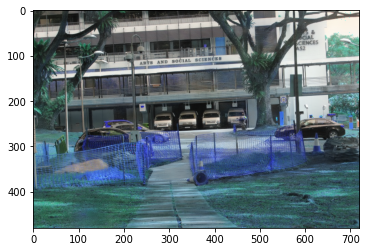

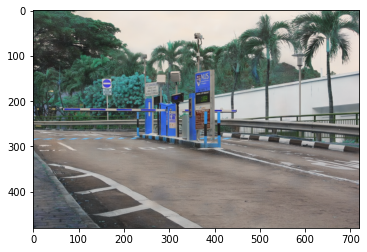

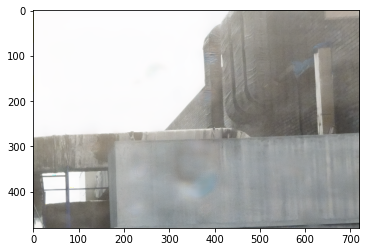

In [ ]:
#Impresion de las imagenes despues de ser restauradas.
for i in range(3):
  plt.figure()
  plt.imshow(cumulative_image[i])